In [5]:
import os
import sys

import pandas as pd
import numpy as np

from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms, utils
from torchvision.utils import save_image, make_grid
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

## Данные и модель

In [6]:
from dataset import ArchDataset, GS_NEGATIVE_PATHS, GS_POSITIVE_PATHS, GS_NEGATIVE_COORDS, GS_POSITIVE_COORDS

In [7]:
from model import VQVAE

# Параметры модели и обучения

In [8]:
EMBED_DIM = 64
NUM_EMBEDS = 4

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [10]:
results_dir = f'../vq_vae_training_sasgis_results/v2_256pix_gray_{str(EMBED_DIM).zfill(2)}embdim_{str(NUM_EMBEDS).zfill(2)}embeds'
res_img_path = f'v2_256pix_gray_{str(EMBED_DIM).zfill(2)}embdim_{str(NUM_EMBEDS).zfill(2)}embeds'
checkpoint_path = f'{results_dir}/checkpoint_9.pth'

In [11]:
params = {
    'batch_size': 1,
    'img_size': 256,
    'channels': 1,
    'embedding_dim': EMBED_DIM,
    'num_embeddings': NUM_EMBEDS,
    'beta': 0.25,
    'n_epochs': 10,
}

# Датасет

In [12]:
transform_nocrop_256_grayscale = transforms.Compose([
    # transforms.CenterCrop((256, 256)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [13]:
torch.manual_seed(42);

In [14]:
train_dataset = ArchDataset(
    img_paths=GS_NEGATIVE_PATHS, 
    coords=GS_NEGATIVE_COORDS, 
    anomalies=False, 
    transform=transform_nocrop_256_grayscale
)
train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)

anomalies_dataset = ArchDataset(
    img_paths=GS_POSITIVE_PATHS, 
    coords=GS_POSITIVE_COORDS, 
    anomalies=True, 
    transform=transform_nocrop_256_grayscale
)
anomalies_loader = DataLoader(anomalies_dataset, batch_size=params['batch_size'], shuffle=False)

In [15]:
print(f'train: {len(train_dataset)} images, {len(train_loader)} batches')
print(f'anomalies: {len(anomalies_dataset)} images, {len(anomalies_loader)} batches')

train: 99254 images, 99254 batches
anomalies: 165 images, 165 batches


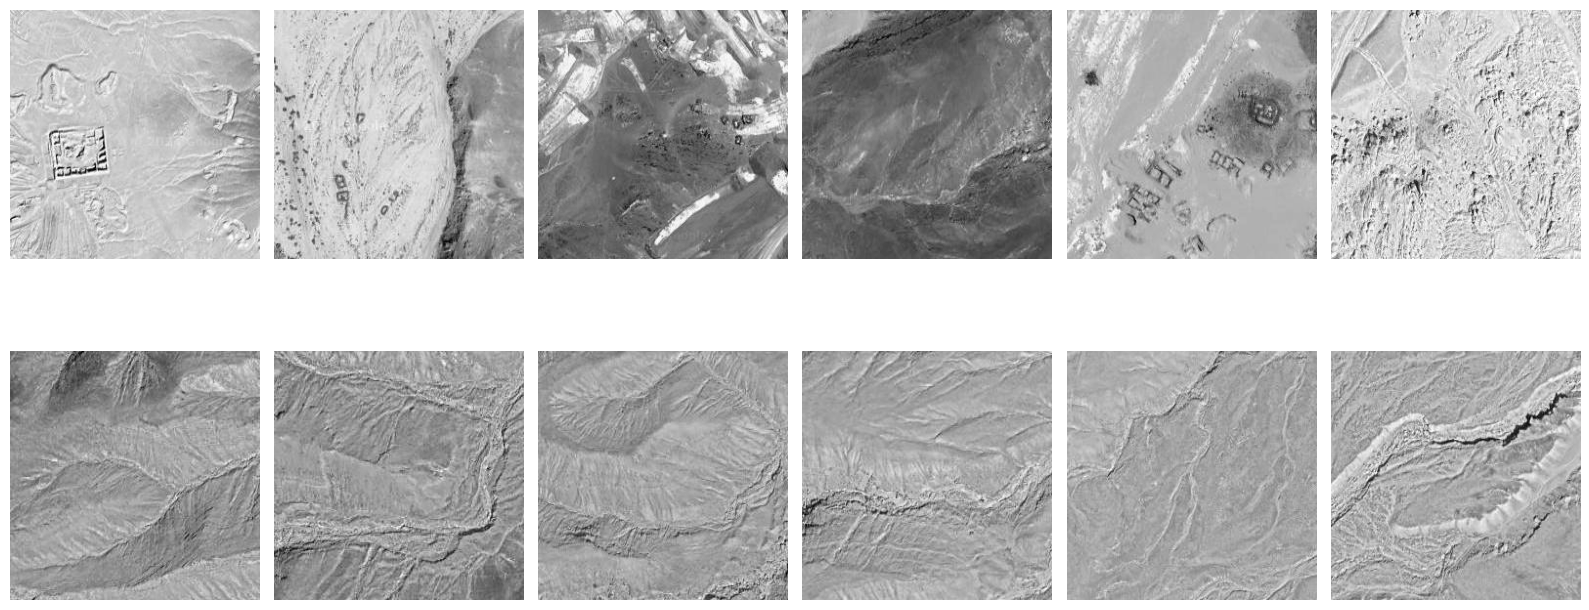

In [16]:
ncols = 6

fig, axs = plt.subplots(nrows=2, ncols=ncols, figsize=(16, 8))
for i in range(ncols):
    axs[0, i].axis('off')
    axs[1, i].axis('off')
    axs[0, i].imshow(anomalies_dataset[i][0].permute(1, 2, 0), cmap='gray')
    axs[1, i].imshow(train_dataset[i][0].permute(1, 2, 0), cmap='gray')
fig.tight_layout()
fig.show()

# Модель

In [17]:
model = VQVAE(
    in_channels=params['channels'],
    img_size=params['img_size'],
    
    embedding_dim=params['embedding_dim'],
    num_embeddings=params['num_embeddings'],
    beta=params['beta']
)

model.load_state_dict(torch.load(checkpoint_path, map_location=device))

<All keys matched successfully>

# Смотрим

In [24]:
import lpips

loss_fn_alex = lpips.LPIPS(net='alex')


from torchvision.models import vit_b_16, ViT_B_16_Weights

# vit_model = vit_b_16(weights='ViT_B_16_Weights.IMAGENET1K_V1') 
weights = ViT_B_16_Weights.IMAGENET1K_V1
vit_model = vit_b_16(weights=weights)

# preprocess = weights.transforms(antialias=True)!!!

vit_model.heads = torch.nn.Identity()
vit_model.eval();

from sklearn.metrics.pairwise import cosine_similarity

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /tmp/xdg_cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:04<00:00, 50.8MB/s] 


Loading model from: /home/jupyter/.local/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /tmp/xdg_cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:19<00:00, 17.8MB/s] 


In [77]:
def load_image(names):
    imgs = []
    for name in names:
        img = transform_nocrop_256_grayscale(Image.open(name).convert('RGB'))
        imgs.append(img)
    return imgs

def align_image(img):
    return (img - img.min()) / (img.max() - img.min())

def draw_image(imgs):
    fig, axes = plt.subplots(ncols=len(imgs) , figsize=(len(imgs) * 2, 2))

    if len(imgs) == 1:
        img = imgs[0]
        axes.imshow(align_image(img).permute(1, 2, 0))
    else:
        for i, img in enumerate(imgs): 
            axes[i].imshow(align_image(img).permute(1, 2, 0))
    plt.show()

In [78]:
def vit_cosine_similarity(img1, img2):

    assert len(img1.shape) == len(img2.shape) == 3,\
        f'expected images of shape C x W x H, got {img1.shape=} {img2.shape=}'

    assert img1.shape[0] == img2.shape[0],\
        f'different number of channels: {img1.shape[0]=} {img2.shape[0]=}'
    

    if img1.shape[0] == 1:  # grayscale
        img1 = img1.repeat(3, 1, 1)
        img2 = img2.repeat(3, 1, 1)

    resize = transforms.Resize(size=224, antialias=True)

    img1 = resize(img1.unsqueeze(0))
    img2 = resize(img2.unsqueeze(0))

    features1 = vit_model(img1).detach().numpy()
    features2 = vit_model(img2).detach().numpy()

    sim = cosine_similarity(features1, features2)
    return sim[0, 0].item()


In [79]:
@torch.no_grad()
def apply_model(model, n_neg=2, n_pos=2, other_image_names=['cat_256.png']):
    
    negative_examples = torch.stack([train_dataset[i][0].to(device) for i in np.random.randint(0, 100, n_neg)], dim=0)
    positive_examples = torch.stack([anomalies_dataset[i][0].to(device) for i in np.random.randint(0, 100, n_pos)], dim=0)
    other_examples =  torch.stack([anomaly.to(device) for anomaly in load_image(other_image_names)], dim=0)

    examples = torch.concat((negative_examples, positive_examples, other_examples), dim=0)
    
    print(f'{len(examples)=}')
    
    reconstructions = model(examples)[0]

    titles = ['train' for _ in range(n_neg)] + ['anomaly' for _ in range(n_pos)] + ['extra' for _ in range(len(other_image_names))]
    return examples, reconstructions, titles



In [83]:
@torch.no_grad()
def anomaly_detection(examples, reconstructions, titles, img_path=None):
    ncols = len(examples)
    nrows = 2
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(6 * ncols, 6 * nrows))

    data = torch.cat([examples[None], reconstructions[None]], dim=0)
    print(data.shape)
    for row in range(nrows):
        for col in range(ncols):
            if row == 1:
                
                axes[row - 1, col].set_title(f'{titles[col]}')

                similarity_cosine = vit_cosine_similarity(data[row - 1, col].to('cpu'), data[row, col].to('cpu'))
                similarity_lpips = loss_fn_alex(data[row - 1, col].to('cpu'), data[row, col].to('cpu'))[0, 0, 0, 0].item()
                # axes[row, col].set_title(f'lpips: {np.round(similarity_lpips, 2)} cosine: {np.round(similarity_cosine, 2)}')
            
            cmap = 'gray' if data[row, col].shape[0] == 1 else None
            axes[row, col].imshow(align_image(data[row, col].to('cpu')).permute(1, 2, 0), cmap=cmap)
            axes[row, col].axis('off')
            
    if img_path:
        plt.savefig(img_path)
    
    plt.show();
    


len(examples)=5
torch.Size([2, 5, 1, 256, 256])


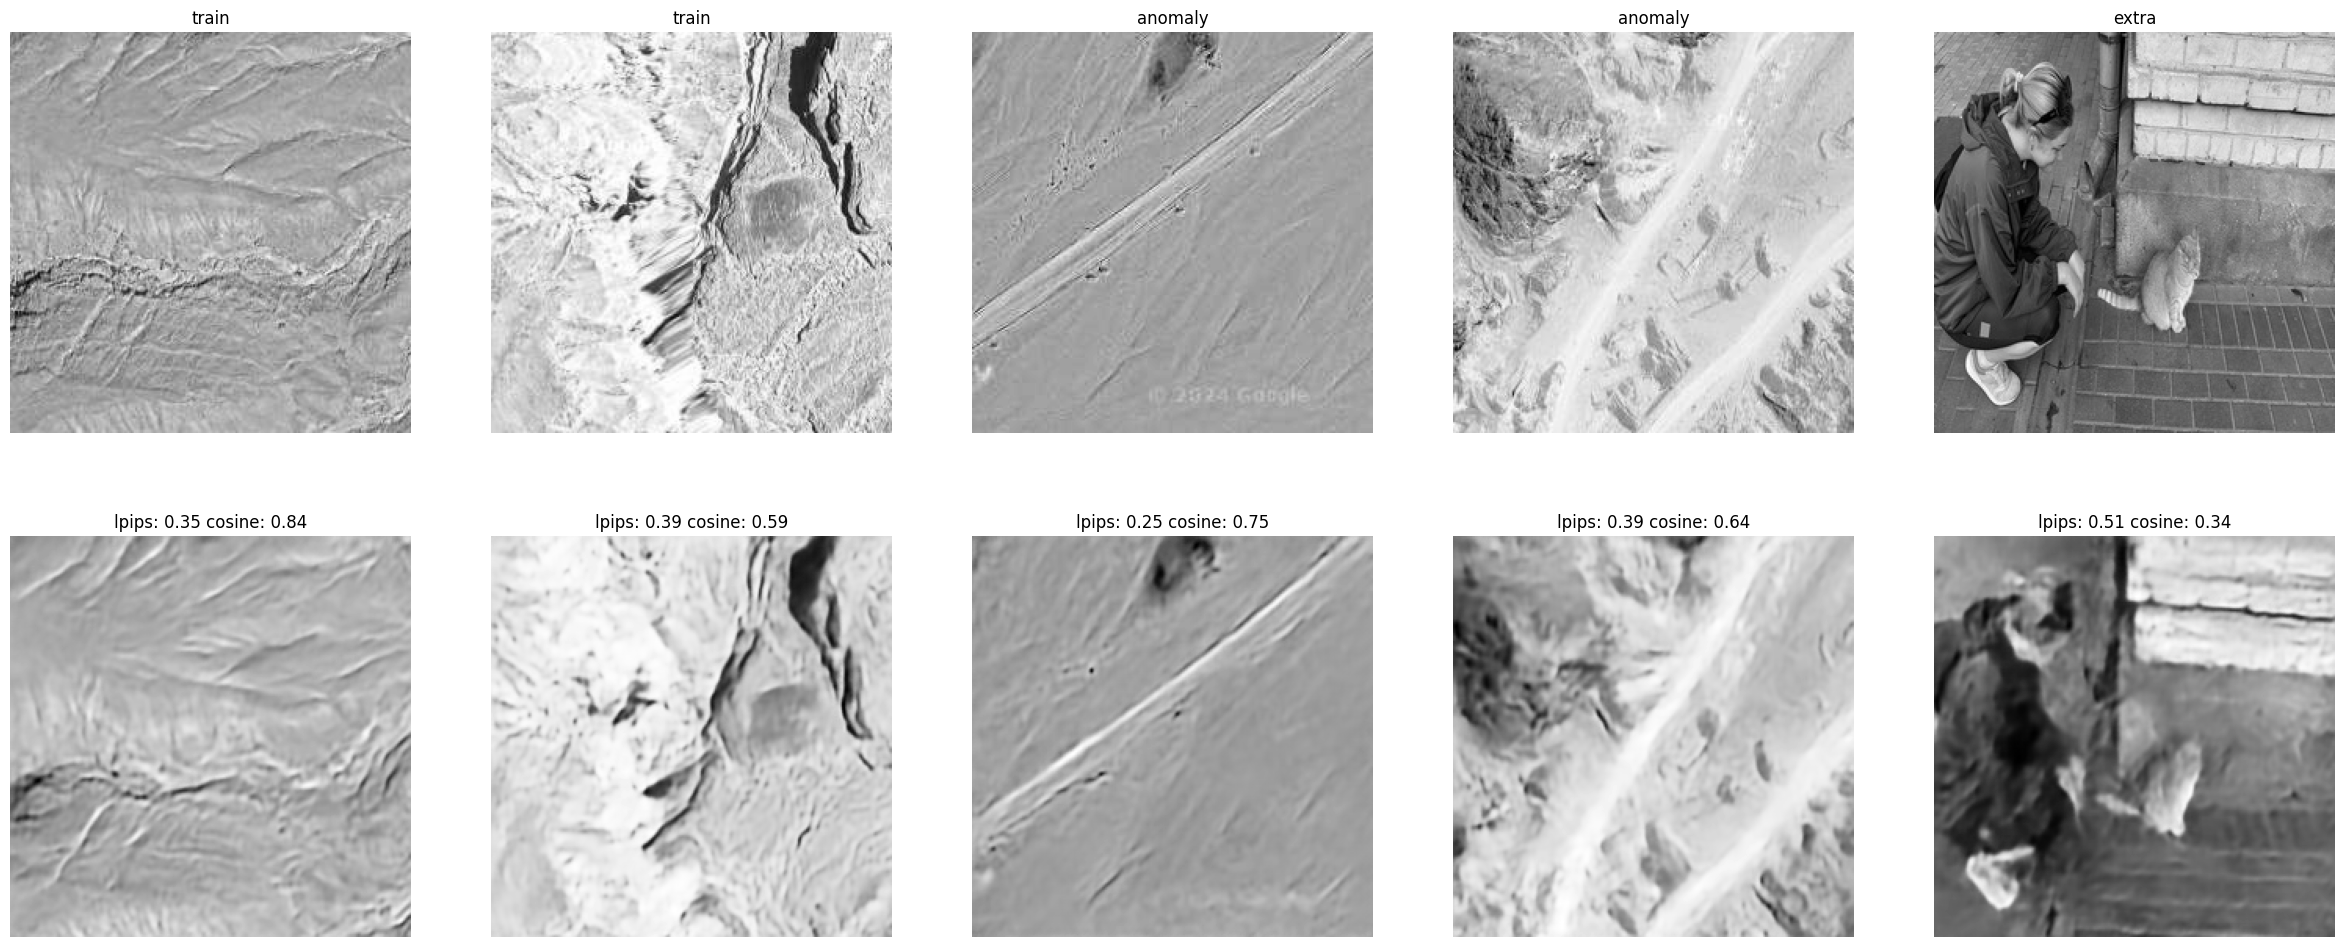

In [84]:
examples, reconstructions, titles = apply_model(model, 2, 2)
anomaly_detection(examples, reconstructions, titles, img_path=f'{res_img_path}_1')

len(examples)=5
torch.Size([2, 5, 1, 256, 256])


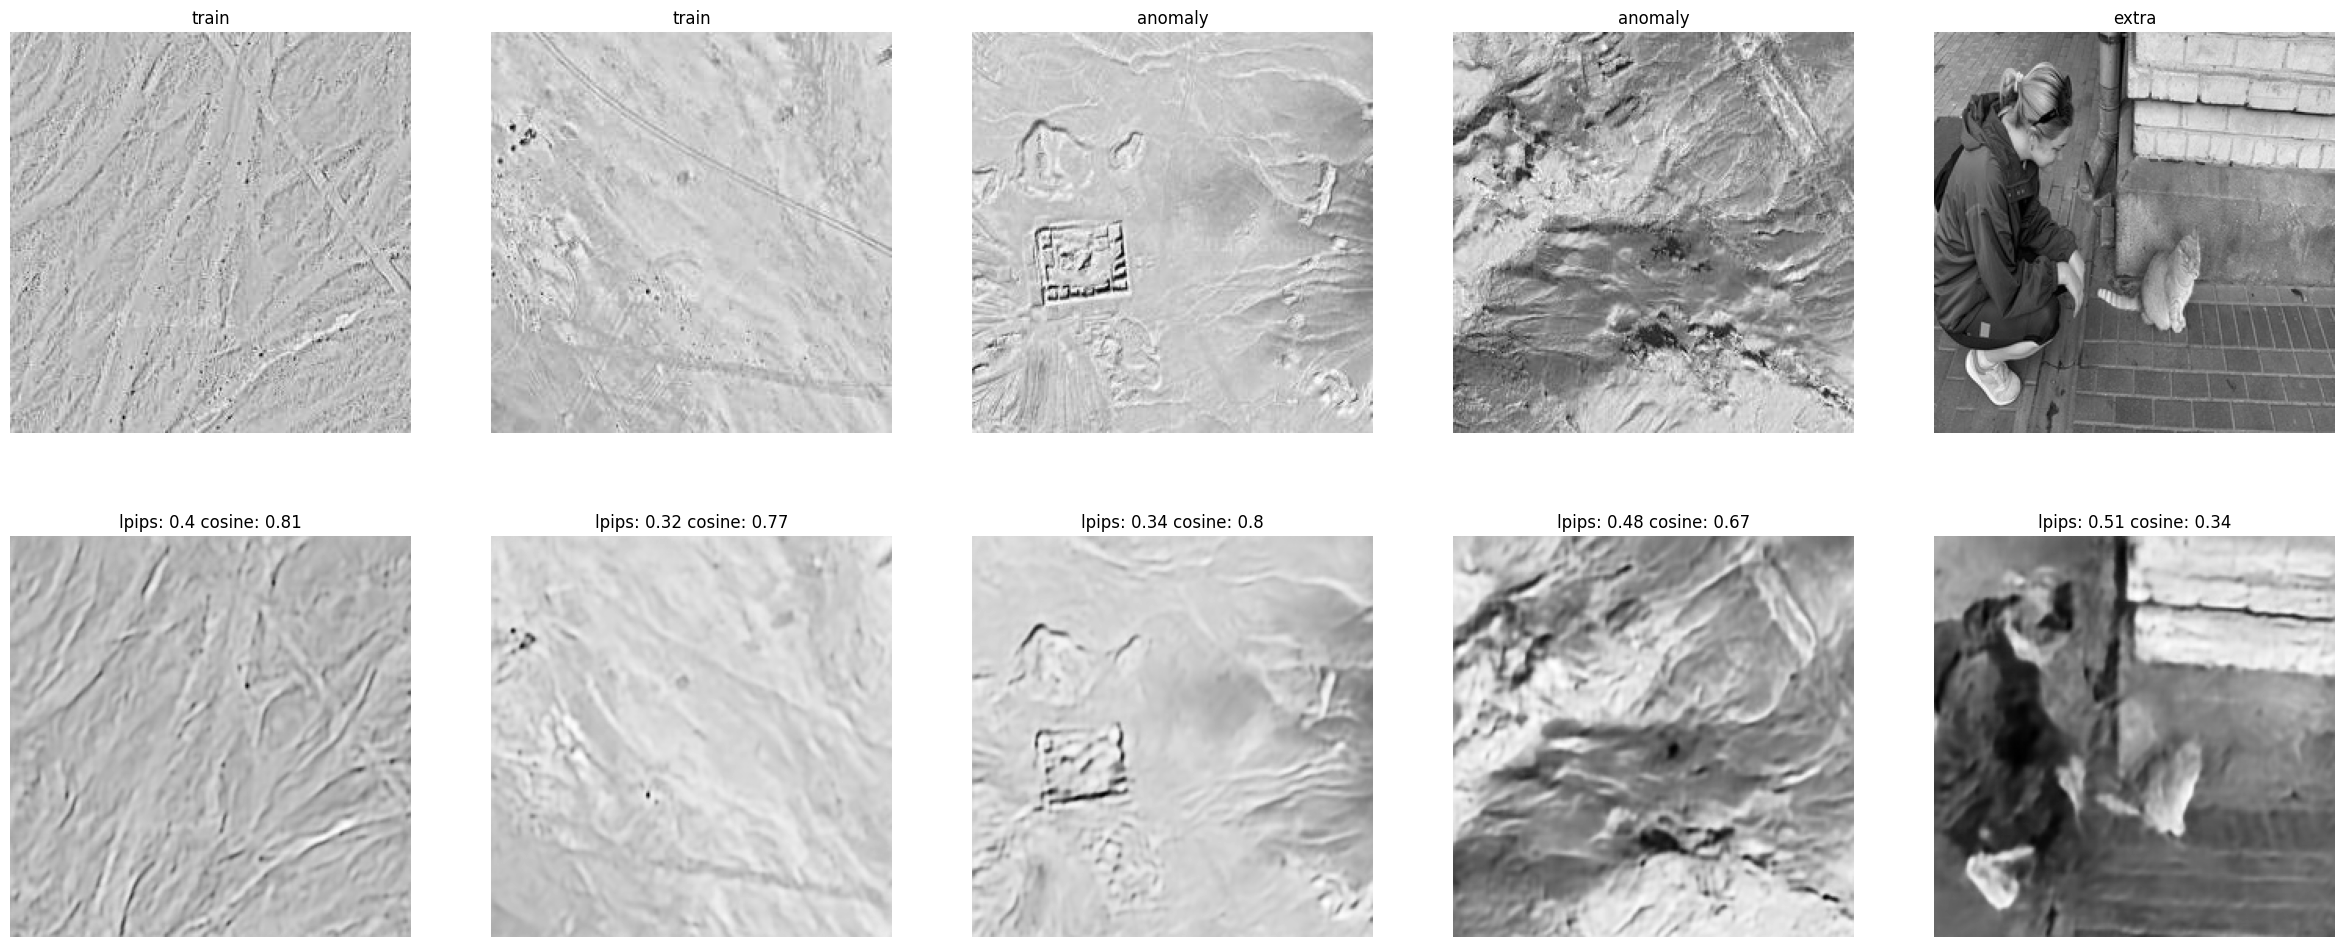

In [86]:
examples, reconstructions, titles = apply_model(model, 2, 2)
anomaly_detection(examples, reconstructions, titles, img_path=f'{res_img_path}_2')

In [152]:
len(anomalies_dataset)

165

In [18]:
def f(i):
    img = train_dataset[i][0]
    rec = model(img[None, :, :, :])[0][0].detach().numpy()
    return (img[0] - rec[0]).max() - (img[0] - rec[0]).min(), (img[0] - rec[0]).min(), (img[0] - rec[0]).max()

In [154]:
fs = []
for i in tqdm(range(400)):
    fs.append(f(i)[2].item())

100%|██████████| 400/400 [02:07<00:00,  3.14it/s]


In [19]:
def g(i):
    img = anomalies_dataset[i][0]
    rec = model(img[None, :, :, :])[0][0].detach().numpy()
    return (img[0] - rec[0]).max() - (img[0] - rec[0]).min(), (img[0] - rec[0]).min(), (img[0] - rec[0]).max()

In [156]:
gs = []
for i in tqdm(range(165)):
    gs.append(g(i)[2].item())

100%|██████████| 165/165 [00:51<00:00,  3.21it/s]


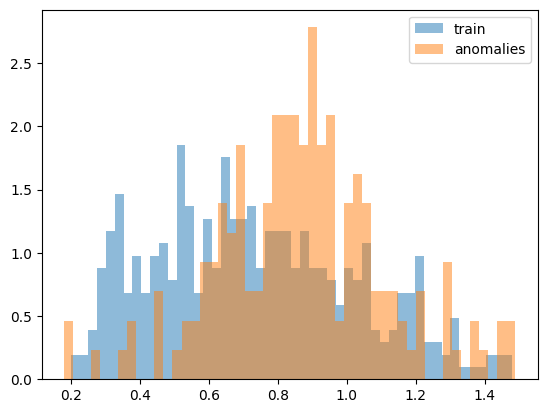

In [162]:
plt.hist(fs, alpha=0.5, bins=50, density=True, label='train')
plt.hist(gs, alpha=0.5, bins=50, density=True, label='anomalies')
plt.legend();
plt.savefig('wow');

In [177]:
fs = np.array(fs)
gs = np.array(gs)

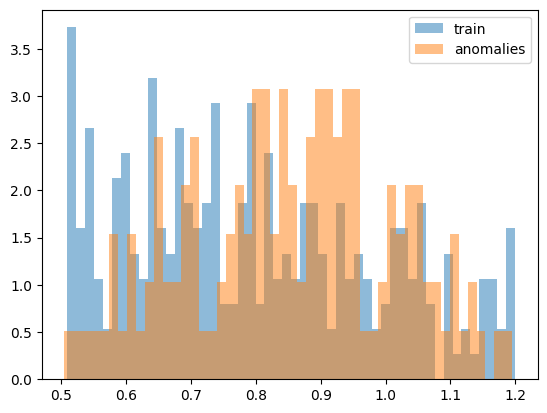

In [178]:
plt.hist(fs[(fs > 0.5) & (fs < 1.2)], alpha=0.5, bins=50, density=True, label='train')
plt.hist(gs[(gs > 0.5) & (gs < 1.2)], alpha=0.5, bins=50, density=True, label='anomalies')
plt.legend();
# plt.savefig('wow');

In [182]:
((fs > 0.5) & (fs < 1.2)).sum() / 400

0.68

In [183]:
((gs > 0.5) & (gs < 1.2)).sum() / 165

0.8545454545454545

In [184]:
fmins = []
for i in tqdm(range(400)):
    fmins.append(f(i)[1].item())

100%|██████████| 400/400 [02:09<00:00,  3.08it/s]


In [186]:
gmins = []
for i in tqdm(range(165)):
    gmins.append(g(i)[1].item())

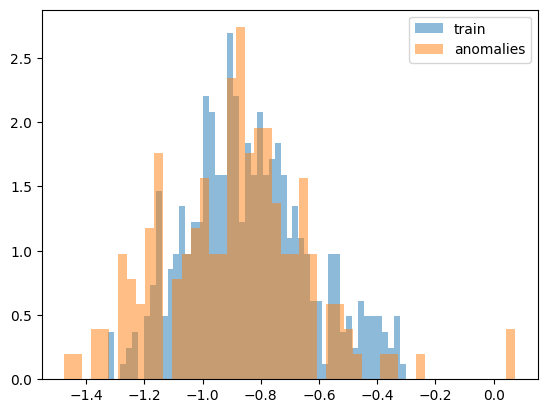

In [188]:
plt.hist(fmins, alpha=0.5, bins=50, density=True, label='train')
plt.hist(gmins, alpha=0.5, bins=50, density=True, label='anomalies')
plt.legend();

In [20]:
img = anomalies_dataset[4][0]
# img = train_dataset[12][0]

In [21]:
img.shape

torch.Size([1, 256, 256])

In [22]:
rec = model(img[None, :, :, :])[0][0].detach().numpy()

In [23]:
rec.shape

(1, 256, 256)

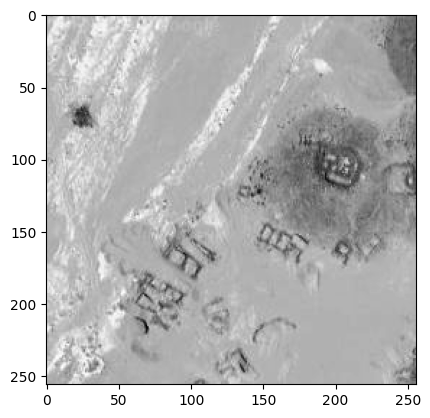

In [24]:
plt.imshow(img[0], cmap='gray')

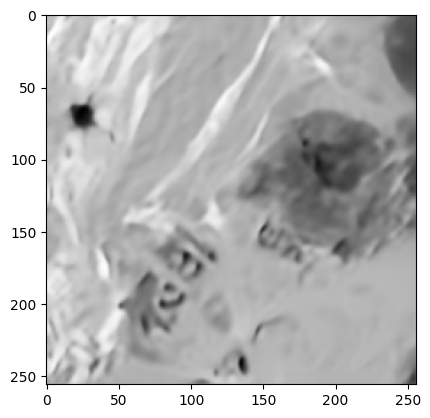

In [25]:
plt.imshow(rec[0], cmap='gray')

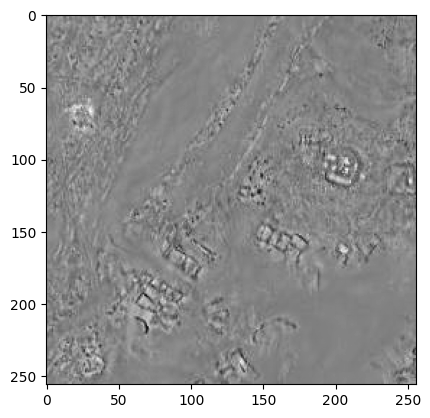

In [26]:
plt.imshow((img[0] - rec[0]), cmap='gray')

In [27]:
(img[0] - rec[0]).min(), (img[0] - rec[0]).max()

(tensor(-0.8442), tensor(0.7910))

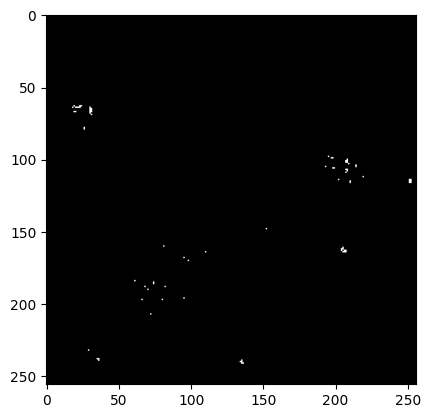

In [28]:
plt.imshow(((img[0] - rec[0]) > 0.5), cmap='gray')

In [86]:
def max_cluster_sz(img):
    rec = model(img[None, :, :, :])[0][0].detach().numpy()
    src = ((img[0] - rec[0]) > 0.5).int().numpy()
    src = np.array(src * 255, dtype=np.uint8)
    ret, thresh = cv2.threshold(src, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)  
    # You need to choose 4 or 8 for connectivity type
    connectivity = 4  
    output = cv2.connectedComponentsWithStats(thresh, connectivity, cv2.CV_32S)
    # The first cell is the number of labels
    # num_labels = output[0]
    # The second cell is the label matrix
    # labels = output[1]
    # The third cell is the stat matrix
    stats = output[2]
    # The fourth cell is the centroid matrix
    # centroids = output[3]
    return np.sort(stats[:, -1])[-2] if len(stats) > 1 else 0

In [114]:
def sum_cluster_sz(img):
    rec = model(img[None, :, :, :])[0][0].detach().numpy()
    src = ((img[0] - rec[0]) > 0.5).int().numpy()
    src = np.array(src * 255, dtype=np.uint8)
    ret, thresh = cv2.threshold(src, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)  
    # You need to choose 4 or 8 for connectivity type
    connectivity = 4  
    output = cv2.connectedComponentsWithStats(thresh, connectivity, cv2.CV_32S)
    # The first cell is the number of labels
    # num_labels = output[0]
    # The second cell is the label matrix
    # labels = output[1]
    # The third cell is the stat matrix
    stats = output[2]
    # The fourth cell is the centroid matrix
    # centroids = output[3]
    return np.sum(sorted(stats[:, -1])[: -1]) if len(stats) > 1 else 0

In [116]:
img = anomalies_dataset[4][0]
sum_cluster_sz(img)

82

In [107]:
max_cluster_szs = []
for img in tqdm(anomalies_dataset):
    max_cluster_szs.append(max_cluster_sz(img[0]))

100%|██████████| 165/165 [00:53<00:00,  3.08it/s]


In [108]:
max_cluster_szs_train = []
for i in tqdm(range(400)):
    img = train_dataset[i]
    max_cluster_szs_train.append(max_cluster_sz(img[0]))

100%|██████████| 400/400 [02:05<00:00,  3.19it/s]


In [117]:
sum_cluster_szs = []
for img in tqdm(anomalies_dataset):
    sum_cluster_szs.append(sum_cluster_sz(img[0]))

100%|██████████| 165/165 [00:50<00:00,  3.26it/s]


In [124]:
sum_cluster_szs_train = []
for i in tqdm(range(400)):
    img = train_dataset[i]
    sum_cluster_szs_train.append(sum_cluster_sz(img[0]))

100%|██████████| 400/400 [02:12<00:00,  3.01it/s]


In [109]:
max_cluster_szs_train = np.array(max_cluster_szs_train)
max_cluster_szs = np.array(max_cluster_szs)

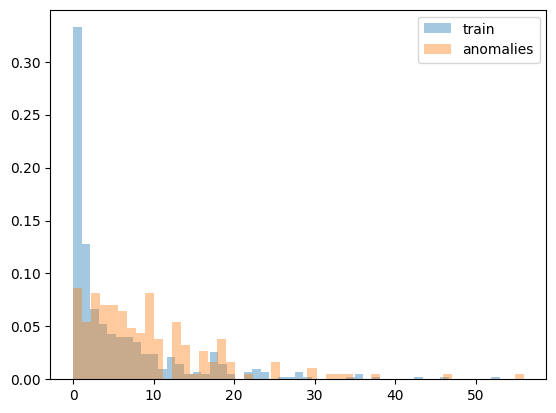

In [110]:
plt.hist(max_cluster_szs_train, alpha=0.4, bins=50, density=True, label='train')
plt.hist(max_cluster_szs, alpha=0.4, bins=50, density=True, label='anomalies')
plt.legend();

In [128]:
sum_cluster_szs_train = np.array(sum_cluster_szs_train)
sum_cluster_szs = np.array(sum_cluster_szs)

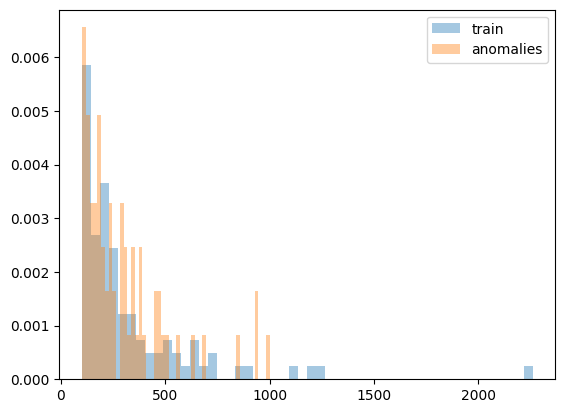

In [132]:
plt.hist(sum_cluster_szs_train[sum_cluster_szs_train > 100], alpha=0.4, bins=50, density=True, label='train')
plt.hist(sum_cluster_szs[sum_cluster_szs > 100], alpha=0.4, bins=50, density=True, label='anomalies')
plt.legend();